# GARCH Modeling

This notebook explores modeling volatility in financial time series using GARCH models. Volatility is the degree of variation of a trading price series over time, and it often exhibits clustering behavior known as conditional heteroskedasticity, where periods of high volatility tend to cluster together. The ARCH model introduced this concept by modeling variance as a function of past squared errors, and the GARCH model extends this by including past variances as well, providing a more flexible and widely used framework for volatility modeling.

## 1 Imports & Helpers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model

## 2 Load Data

We load a time series dataset, such as returns or price data, from a CSV file. We will compute log returns if the data is a price series.

In [2]:
# Load minute-level OHLC data and index by the timestamp
df = pd.read_csv(
    '/Users/mchildress/Active Code/ts_basics/data/bnbusdt_1m.csv',
    parse_dates=['open_time'],
    index_col='open_time'
)

# Pull out the 'close' column and make sure it's float
prices = df['close'].astype(float)

# Compute log returns on the price series
returns = np.log(prices).diff().dropna()

## 3 Fit ARIMA & check residuals

We fit a simple ARIMA model to capture the mean dynamics, then examine residuals to ensure no autocorrelation remains.

/var/folders/yj/3s0hc5nn3qlg4lqp7wmfgq_c0000gn/T/ipykernel_26088/2678527110.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  returns_5min = returns.resample('5T').sum()
/Users/mchildress/.pyenv/versions/3.11.12/envs/dream/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


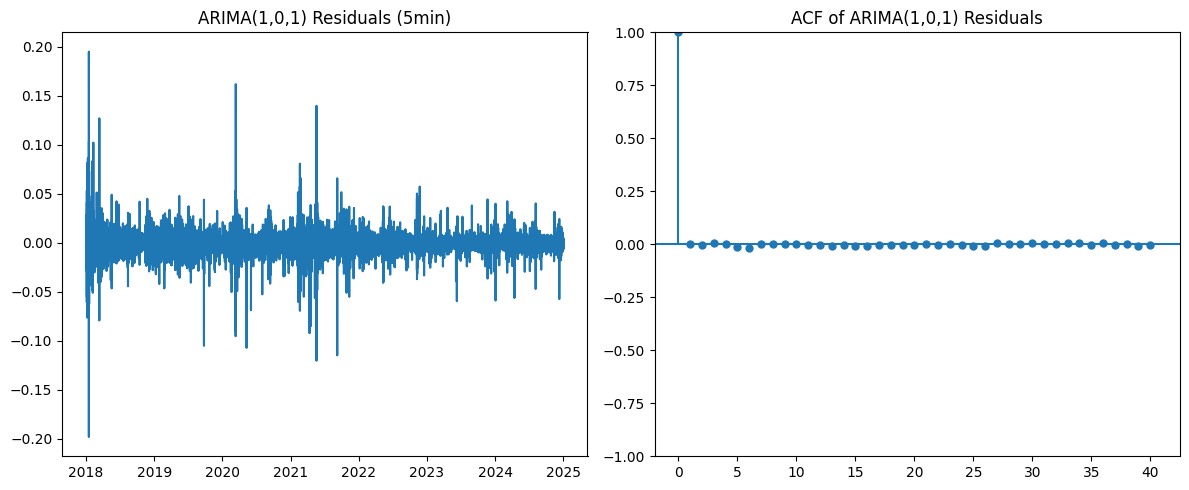

In [3]:
from statsmodels.tsa.arima.model import ARIMA

# downsample one-minute log returns into 5‑minute aggregate returns to speed up fitting
returns_5min = returns.resample('5T').sum()

# fit ARIMA(1,0,1) on the 5‑minute returns using CSS estimator and limited iterations
model = ARIMA(returns_5min, order=(1,0,1))
res = model.fit()

# plot residuals and ACF
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(res.resid)
plt.title('ARIMA(1,0,1) Residuals (5min)')
plt.subplot(122)
plot_acf(res.resid, ax=plt.gca(), lags=40)
plt.title('ACF of ARIMA(1,0,1) Residuals')
plt.tight_layout()
plt.show()


## 4 Test for ARCH effects

We plot the autocorrelation of squared residuals to check for volatility clustering, a sign of ARCH effects.

<Figure size 600x400 with 0 Axes>

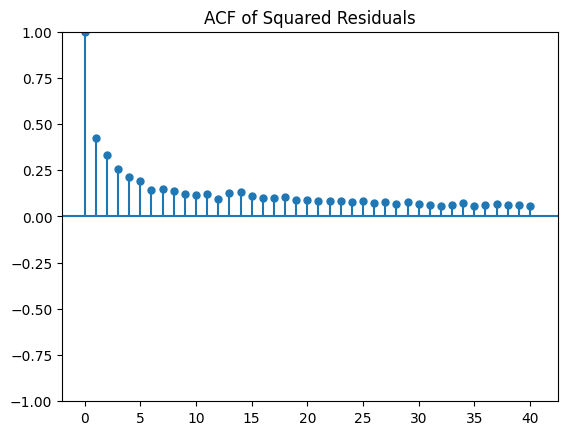

In [4]:
plt.figure(figsize=(6,4))
plot_acf(res.resid**2, lags=40)
plt.title('ACF of Squared Residuals')
plt.show()

## 5 Fit GARCH(1,1)

We fit a GARCH(1,1) model to capture volatility clustering and time-varying variance.

In [5]:
garch = arch_model(res.resid, vol='Garch', p=1, q=1)
res_garch = garch.fit()
print(res_garch.summary())

/Users/mchildress/.pyenv/versions/3.11.12/envs/dream/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.023e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -3487558.0260060886
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3487558.02384662
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


/Users/mchildress/.pyenv/versions/3.11.12/envs/dream/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:            3.48756e+06
Distribution:                  Normal   AIC:                      -6.97511e+06
Method:            Maximum Likelihood   BIC:                      -6.97506e+06
                                        No. Observations:               736704
Date:                Thu, May 01 2025   Df Residuals:                   736703
Time:                        15:11:51   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -3.6480e-12  2.806e-06 -1.300e-06      1.

## 6 Diagnose GARCH residuals

We check standardized residuals and their autocorrelations to assess model fit.

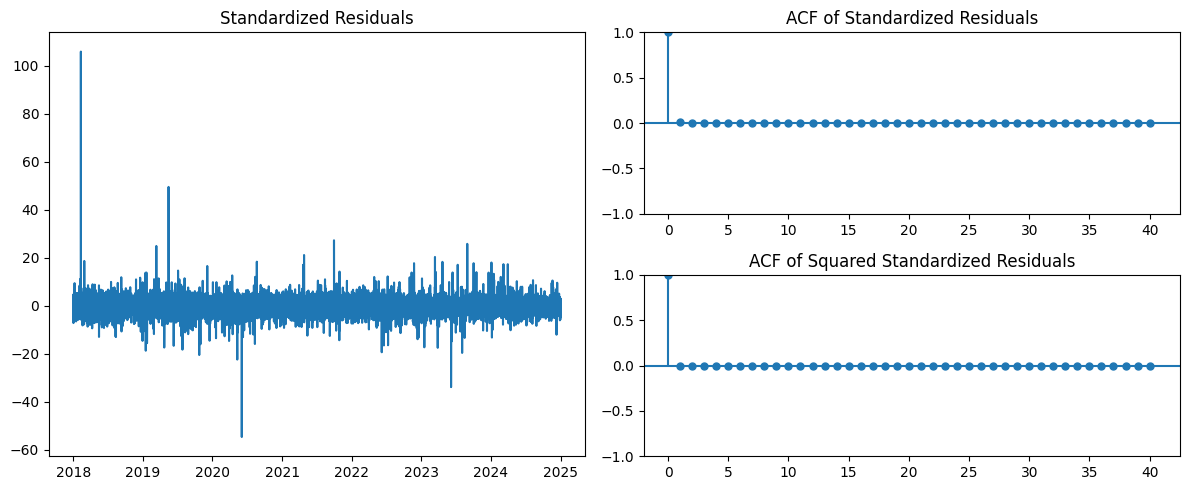

In [6]:
std_resid = res_garch.std_resid

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(std_resid)
plt.title('Standardized Residuals')
plt.subplot(222)
plot_acf(std_resid, lags=40, ax=plt.gca())
plt.title('ACF of Standardized Residuals')
plt.subplot(224)
plot_acf(std_resid**2, lags=40, ax=plt.gca())
plt.title('ACF of Squared Standardized Residuals')
plt.tight_layout()
plt.show()

## 7 Plot estimated volatility

We plot the estimated conditional volatility from the GARCH model.

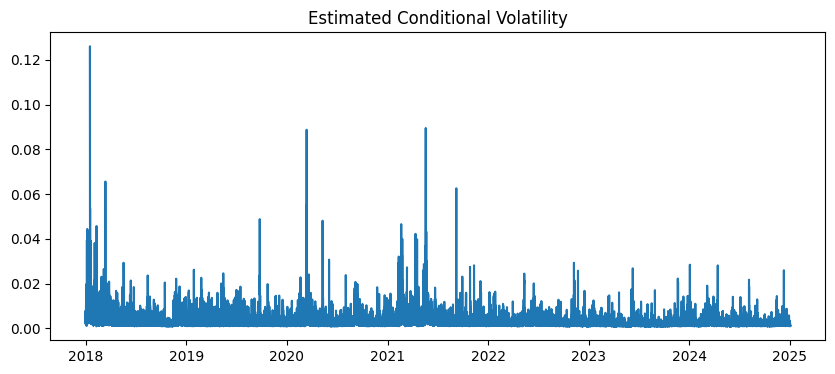

In [7]:
plt.figure(figsize=(10,4))
plt.plot(res_garch.conditional_volatility)
plt.title('Estimated Conditional Volatility')
plt.show()

# 8 Volatility Modeling in High‑Frequency Returns

## Goal: Modeling Volatility in High‑Frequency Returns

- **Data**: One‑minute “close” prices of an asset (BNB/USDT), converted to log‑returns.  
- **Motivation**: Financial returns often show “volatility clustering” (big moves tend to be followed by more big moves). We want a model that captures this behavior.

---

## Remove Serial Correlation in the Mean via ARIMA

1. **Aggregate to 5‑minute returns**  
   To speed things up, we summed one‑minute returns into non‑overlapping 5‑minute returns.

2. **Fit ARIMA(1,0,1)**  
   - This is a simple time‑series model with one autoregressive term and one moving‑average term.  
   - **Residuals (left plot)**: After fitting, the series of residuals looks like “noise” around zero—no obvious predictable pattern.  
   - **ACF of residuals (right plot)**: All autocorrelations (lags ≥1) are essentially zero; the ARIMA mean model has removed linear dependence successfully.

> Accounted for the predictable part of the returns. What remains (ARIMA residuals) is what we’ll model for time‑varying volatility.

---

## Check for ARCH Effects

- **Squared‐residual ACF**: Plotted the autocorrelation of the squared ARIMA residuals.  
- **Observation**: There are large, slowly decaying positive autocorrelations out to many lags.

> Big shocks tend to be followed by big shocks (in magnitude), and small by small ARCH (autoregressive conditional heteroskedasticity). This is a  model that lets today’s volatility depend on past information.

---

## Fit a GARCH(1,1) Model

- **GARCH(1,1)**:  
  - Variance at time _t_ depends on  
    1. A constant term (ω),  
    2. The previous shock’s squared magnitude (α·ε²ₜ₋₁), and  
    3. The previous period’s variance (β·σ²ₜ₋₁).  
- **Conditional volatility plot**: Shows the model’s estimate of how volatility rises and falls over time, capturing clusters of turbulence.

---

## Model Output & Interpretation

| Parameter    | Estimate     | Plain English                                                                 |
|:------------:|:------------:|:-------------------------------------------------------------------------------|
| ** (omega)**   | 2.05 × 10⁻⁷   | A tiny “baseline” level of variance.                                           |
| ** (alpha[1])** | 0.20         | Shocks have an immediate effect: 1 unit² shock adds about 0.20 variance next period. |
| ** (beta[1])**  | 0.78         | Volatility persists: 78 % of yesterday’s variance carries into today.          |

- **Sum alpha+beta = 0.98**  
  Almost all past variance and shocks feed into current volatility—volatility is highly persistent.
- **Convergence warnings & scale note**  
  - The optimizer complained about incompatible constraints and that the data were very small in scale.  

> **Bottom Line**:  
> 1. **Mean dynamics** — the residuals have no linear autocorrelation.  
> 2. **Volatility** clearly clusters; a simple GARCH(1,1) does a good job of reproducing that clustering.  
